# 数据收集与清洗

### 数据收集
从gee（google earth engine）云计算平台中获取数据，包括NDVI、SMAP、gridMET等数据。由于数据量较大，选择2016年至2026年美国加利福尼亚州的数据。

创建项目运行以下脚本。云上批处理聚合之后下载csv，导入本项目文件夹。

脚本地址：https://code.earthengine.google.com/6ff74f8bea55f206d27edc2dc534e561

### 数据准备与清洗
对获取到的数据进行清洗，包括缺失值处理、异常值检测与处理等。

In [17]:
import pandas as pd
import numpy as np

import math
import time
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.utils.data as Data

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# 读取数据
df = pd.read_csv('CA_NDVI_SMAP_gridMET_Aligned_2016_2026.csv')

# 时间与清洗
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# 缺测处理
df['soil_moisture'] = df['soil_moisture'].replace(-9999, np.nan)
df = df.dropna().reset_index(drop=True)

# 可选：温度转为摄氏度
df['temp_max'] = df['temp_max'] - 273.15
df['temp_min'] = df['temp_min'] - 273.15

# 划分时间集（示例：训练到2022，之后测试）
train_df = df[df['date'] < '2023-01-01']
test_df  = df[df['date'] >= '2023-01-01']



## 相关性分析


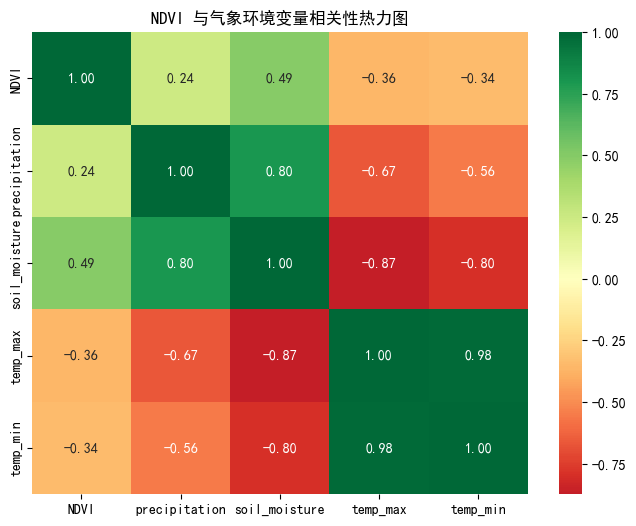

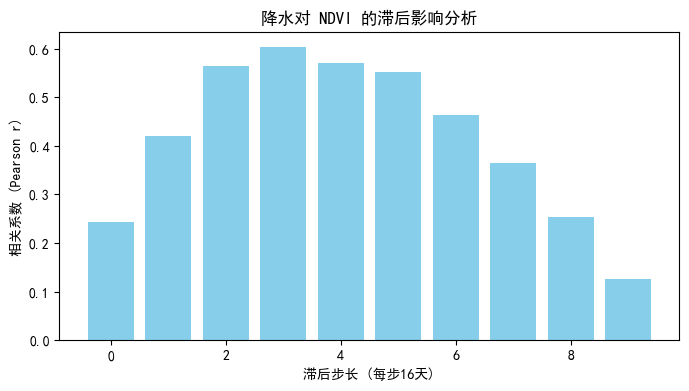

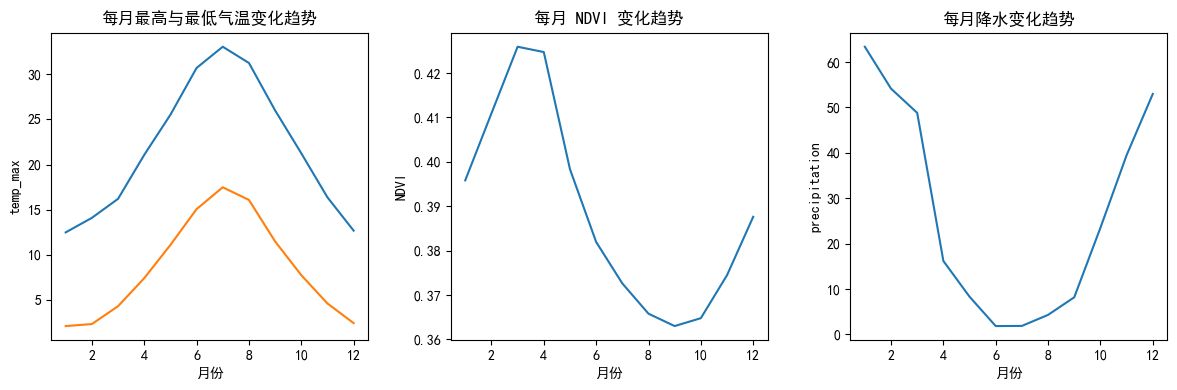

In [18]:
import seaborn as sns

# 确保有 month 列（从 date 提取）
if 'date' in df.columns:
	df['month'] = df['date'].dt.month
else:
	raise ValueError("df 中找不到 'date' 列，请检查数据。")

# 计算相关系数矩阵
corr_matrix = df[['NDVI', 'precipitation', 'soil_moisture', 'temp_max', 'temp_min']].corr()

plt.figure(figsize=(8, 6))
# 字体设置
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt=".2f")
plt.title("NDVI 与气象环境变量相关性热力图")
plt.show()

# 计算不同滞后步长（Lag）下，降水与NDVI的相关性
lags = range(0, 10) # 0到9个周期，每个周期16天
lag_corrs = [df['NDVI'].corr(df['precipitation'].shift(i)) for i in lags]

plt.figure(figsize=(8, 4))
plt.bar(lags, lag_corrs, color='skyblue')
plt.xlabel('滞后步长 (每步16天)')
plt.ylabel('相关系数 (Pearson r)')
plt.title('降水对 NDVI 的滞后影响分析')
plt.show()

# 绘制每月气温、NDVI、降水的平均变化趋势（按月平均，也就是每两个时间步一个月）
df['date'] = pd.to_datetime(df['date'])  # 替换为你的日期列名

# 步骤2：提取月份，生成新的month列（1-12月）
df['month'] = df['date'].dt.month

# 步骤3：绘制趋势图（此时df已有month列，无报错）
plt.figure(figsize=(12, 4))

# 修正：ci参数已弃用，使用errorbar=None替代
plt.subplot(1, 3, 1)
sns.lineplot(x='month', y='temp_max', data=df, errorbar=None)
sns.lineplot(x='month', y='temp_min', data=df, errorbar=None)
plt.title('每月最高与最低气温变化趋势')
plt.xlabel('月份')  # 可选：添加x轴标签，更清晰

plt.subplot(1, 3, 2)
sns.lineplot(x='month', y='NDVI', data=df, errorbar=None)
plt.title('每月 NDVI 变化趋势')
plt.xlabel('月份')

plt.subplot(1, 3, 3)
sns.lineplot(x='month', y='precipitation', data=df, errorbar=None)
plt.title('每月降水变化趋势')
plt.xlabel('月份')

plt.tight_layout()
plt.show()

# 单步预测
使用sarima和lstm模型进行单步预测。

### sarima
seasonal arima是一种时间序列模型，用于预测具有季节性趋势的时间序列数据。它是arima模型的扩展，考虑了季节性因素。主要参数包括：

1. 非季节性部分（p, d, q）：与arima模型相同，用于描述非季节性趋势。

2. 季节性部分（P, D, Q, s）：用于描述季节性趋势。其中，P, D, Q 分别对应季节性部分的自回归、差分和移动平均阶数，s 表示季节性周期。   

最终结果较差，不能很好的学习规律

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
y_train = train_df['NDVI']
y_test  = test_df['NDVI']

# SARIMA 参数
# (p,d,q)=(1,1,1)，季节项 (P,D,Q,m)=(1,1,1,23)
model = SARIMAX(
    y_train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 23),
    enforce_stationarity=False,
    enforce_invertibility=False
)

res = model.fit(disp=False)

# 预测测试集长度
pred = res.forecast(steps=len(y_test))

# 评估
mae  = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)  # 此处不传入squared参数，默认返回MSE
rmse = np.sqrt(mse)
r2   = r2_score(y_test, pred)

print('SARIMA Results')
print('MAE:', mae)
print('RMSE:', rmse)
print('R2:', r2)


SARIMA Results
MAE: 0.02321047171366801
RMSE: 0.03213296192696642
R2: -0.3178618313437709


## 单步lstm

根据过去 3 个月的情况，预测接下来的 16 天。输入输出：输入 $X_{1 \dots m}$，输出仅为 $y_{m+1}$。仅使用了原始气象因子（降水、温度等），没有显式地让模型利用“上一时刻的 NDVI”作为特征。

device: cuda
数据量（行）: 227
  system:index      NDVI       date  precipitation  smap_count  soil_moisture  \
0   2016_01_01  0.352730 2016-01-01      82.037667          16       0.279668   
1   2016_01_17  0.422946 2016-01-17      94.763896          16       0.290748   
2   2016_02_02  0.428428 2016-02-02      16.189782          16       0.239263   
3   2016_02_18  0.431796 2016-02-18      24.571602          16       0.224682   
4   2016_03_05  0.444845 2016-03-05     114.815635          16       0.276569   

    temp_max  temp_min                                    .geo  
0   9.900512  1.061384  {"type":"MultiPoint","coordinates":[]}  
1  12.874430  3.153814  {"type":"MultiPoint","coordinates":[]}  
2  18.208256  4.320971  {"type":"MultiPoint","coordinates":[]}  
3  18.871144  5.248300  {"type":"MultiPoint","coordinates":[]}  
4  16.899393  5.488795  {"type":"MultiPoint","coordinates":[]}  
X_seq shape: (221, 6, 4)
y_seq shape: (221, 1)
train/val/test: (154, 6, 4) (33, 6, 4) (34, 6, 4)


 10%|█         | 8/80 [00:00<00:03, 23.49it/s]

Epoch 001 | train=0.159415 | val=0.252191 | best_val=0.252191
Epoch 005 | train=0.051580 | val=0.039378 | best_val=0.039378
Epoch 010 | train=0.035077 | val=0.059894 | best_val=0.039378
Epoch 015 | train=0.018986 | val=0.017917 | best_val=0.017917


 30%|███       | 24/80 [00:00<00:01, 39.15it/s]

Epoch 020 | train=0.011377 | val=0.026762 | best_val=0.017917
Epoch 025 | train=0.011075 | val=0.022324 | best_val=0.017917
Early stopping at epoch 25, best_val=0.017917


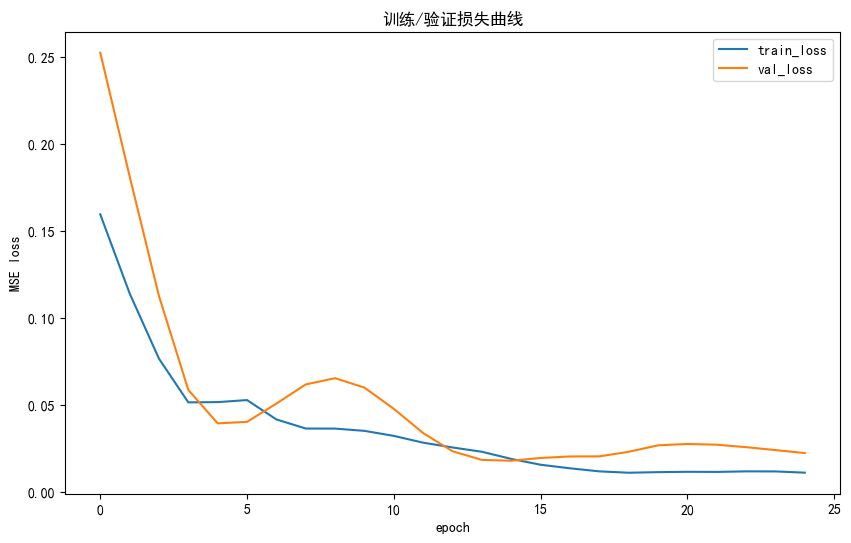

Test inference time: 0.00s
===== LSTM Test Metrics =====
MAE : 0.014378281095919456
RMSE: 0.02310743389002159
R2  : 0.3082009615004998
Saved: NDVI_LSTM_pred.csv


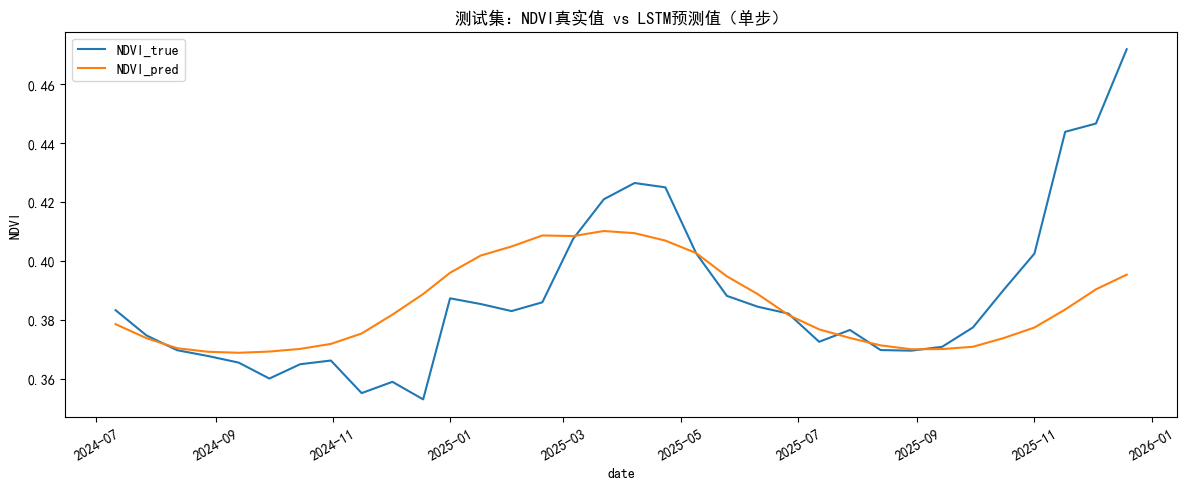

In [20]:
# =========================
# 0) 固定随机种子 & 设备
# =========================
fix_seed = 2025
random.seed(fix_seed)
np.random.seed(fix_seed)
torch.manual_seed(fix_seed)
torch.cuda.manual_seed_all(fix_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


# =========================
# 1) 路径与超参数
# =========================
path_load = r'CA_NDVI_SMAP_gridMET_Aligned_2016_2026.csv'  # 改成你的路径

# 预测设置：16天为一个时间步
m = 6      # 输入窗口长度（6个16天≈3个月）
n = 1      # 输出步长（单步预测 NDVI(t+1)）

# 训练设置
batch_size = 64
epochs = 80
lr = 1e-3

# LSTM结构
hidden_size = 64
num_layers = 2
dropout = 0.2

# early stopping
patience = 10  # 验证集连续patience次不提升就停


# =========================
# 2) 读取与清洗数据
# =========================
df = pd.read_csv(path_load)
# 兼容你可能的列名：date / timestamp
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
elif 'timestamp' in df.columns:
    df['date'] = pd.to_datetime(df['timestamp'])
else:
    raise ValueError("找不到 date/timestamp 列，请检查CSV列名。")

df = df.sort_values('date').reset_index(drop=True)

# 必要列（你现在导出的总表一般是这些）
required_cols = ['NDVI', 'precipitation', 'soil_moisture', 'temp_max', 'temp_min']
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"缺少列: {c}，请检查CSV是否包含该字段。")

# 处理 SMAP 缺测（-9999）
df['soil_moisture'] = df['soil_moisture'].replace(-9999, np.nan)

# 可选：用smap_count做质量过滤（如果存在）
if 'smap_count' in df.columns:
    df = df[df['smap_count'] > 0].copy()

# 丢弃缺失
df = df.dropna(subset=required_cols).reset_index(drop=True)

# 可选：温度从K转℃（不转也可，但报告要说明）
df['temp_max'] = df['temp_max'] - 273.15
df['temp_min'] = df['temp_min'] - 273.15

print("数据量（行）:", len(df))
print(df.head())


# =========================
# 3) Min-Max 归一化（保持与你原代码风格一致）
# =========================
feature_cols = ['precipitation', 'soil_moisture', 'temp_max', 'temp_min']
target_col = 'NDVI'

X_df = df[feature_cols].copy()
y_df = df[[target_col]].copy()

X_min, X_max = X_df.min(), X_df.max()
y_min, y_max = y_df.min(), y_df.max()

# 防止除零
X_den = (X_max - X_min).replace(0, 1)
y_den = (y_max - y_min).replace(0, 1)

X_norm = (X_df - X_min) / X_den
y_norm = (y_df - y_min) / y_den

X_norm = X_norm.values.astype(np.float32)
y_norm = y_norm.values.astype(np.float32)


# =========================
# 4) 构造序列样本 (X: [samples, m, features], y: [samples, 1])
# =========================
X_seq, y_seq, date_seq = [], [], []
for i in range(len(X_norm) - m - n + 1):
    X_seq.append(X_norm[i:i+m, :])
    y_seq.append(y_norm[i+m:i+m+n, 0])  # n=1 -> shape (1,)
    date_seq.append(df['date'].iloc[i+m])  # 预测目标对应的日期

X_seq = np.array(X_seq, dtype=np.float32)
y_seq = np.array(y_seq, dtype=np.float32)  # [samples, 1] when n=1

if n == 1:
    y_seq = y_seq.reshape(-1, 1)

print("X_seq shape:", X_seq.shape)  # (N, m, 4)
print("y_seq shape:", y_seq.shape)  # (N, 1)


# =========================
# 5) 时间序列切分（按时间，不打乱）
# =========================
N = len(X_seq)
train_end = int(N * 0.7)
val_end = int(N * 0.85)

x_train, y_train = X_seq[:train_end], y_seq[:train_end]
x_val, y_val     = X_seq[train_end:val_end], y_seq[train_end:val_end]
x_test, y_test   = X_seq[val_end:], y_seq[val_end:]
date_test        = np.array(date_seq[val_end:])

print("train/val/test:", x_train.shape, x_val.shape, x_test.shape)


# =========================
# 6) Dataset & DataLoader
# =========================
class MyDataSet(Data.Dataset):
    def __init__(self, data_inputs, data_targets):
        self.inputs = torch.tensor(data_inputs, dtype=torch.float32)
        self.labels = torch.tensor(data_targets, dtype=torch.float32)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

    def __len__(self):
        return len(self.inputs)

train_loader = Data.DataLoader(MyDataSet(x_train, y_train), batch_size=batch_size, shuffle=False)
val_loader   = Data.DataLoader(MyDataSet(x_val, y_val), batch_size=batch_size, shuffle=False)
test_loader  = Data.DataLoader(MyDataSet(x_test, y_test), batch_size=batch_size, shuffle=False)


# =========================
# 7) 模型定义（多变量 LSTM 回归）
# =========================
class NDVI_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, out_size=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        out, _ = self.lstm(x)            # out: [B, m, hidden]
        out = out[:, -1, :]              # last step: [B, hidden]
        out = self.fc(out)               # [B, 1]
        return out

model = NDVI_LSTM(
    input_size=len(feature_cols),
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout=dropout,
    out_size=1
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# =========================
# 8) 训练 + 验证（保存最优模型）
# =========================
best_val = float('inf')
no_improve = 0
train_losses, val_losses = [], []

save_path = "best_ndvi_lstm.pth"

def evaluate(loader):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            losses.append(loss.item())
    return float(np.mean(losses))

for epoch in tqdm(range(1, epochs + 1)):
    model.train()
    batch_losses = []
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    tr_loss = float(np.mean(batch_losses))
    va_loss = evaluate(val_loader)

    train_losses.append(tr_loss)
    val_losses.append(va_loss)

    if va_loss < best_val - 1e-8:
        best_val = va_loss
        no_improve = 0
        torch.save(model.state_dict(), save_path)
    else:
        no_improve += 1

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | train={tr_loss:.6f} | val={va_loss:.6f} | best_val={best_val:.6f}")

    if no_improve >= patience:
        print(f"Early stopping at epoch {epoch}, best_val={best_val:.6f}")
        break


# 画loss曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.legend()
plt.title('训练/验证损失曲线')
plt.show()


# =========================
# 9) 测试集预测与反归一化
# =========================
model.load_state_dict(torch.load(save_path, map_location=device))
model.eval()

y_pred_scaled = []
y_true_scaled = []

start_time = time.time()
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        pred = model(xb).cpu().numpy()
        y_pred_scaled.append(pred)
        y_true_scaled.append(yb.numpy())
end_time = time.time()

y_pred_scaled = np.vstack(y_pred_scaled)  # [N, 1]
y_true_scaled = np.vstack(y_true_scaled)  # [N, 1]

# 反归一化（NDVI）
y_pred = y_pred_scaled * y_den.values + y_min.values
y_true = y_true_scaled * y_den.values + y_min.values

y_pred = y_pred.reshape(-1)
y_true = y_true.reshape(-1)

print("Test inference time: {:.2f}s".format(end_time - start_time))


# =========================
# 10) 指标评估
# =========================
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("===== LSTM Test Metrics =====")
print("MAE :", mae)
print("RMSE:", rmse)
print("R2  :", r2)


# =========================
# 11) 保存结果 & 可视化
# =========================
out_df = pd.DataFrame({
    'date': date_test.astype('datetime64[ns]'),
    'NDVI_true': y_true,
    'NDVI_pred': y_pred
})
out_df.to_csv("NDVI_LSTM_pred.csv", index=False, encoding='utf-8-sig')
print("Saved: NDVI_LSTM_pred.csv")

plt.figure(figsize=(12, 5))
plt.plot(out_df['date'], out_df['NDVI_true'], label='NDVI_true')
plt.plot(out_df['date'], out_df['NDVI_pred'], label='NDVI_pred')
plt.xlabel('date')
plt.ylabel('NDVI')
plt.title('测试集：NDVI真实值 vs LSTM预测值（单步）')
plt.legend()
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


#  多步预测

## encoder-decoder lstm（基础seq2seq）
教师强制 (Teacher Forcing)和解码器初始化：在这个版本中，解码器的第一个输入是 zeros（零向量）。这实际上是一个弱点，因为解码器在预测未来第一步时，并不知道当前的 NDVI 到底是多少，只能靠编码器的隐藏状态（Hidden State）死记硬背。

device: cuda
Samples: 219 X: (219, 6, 4) Y: (219, 3)
train/val/test: (153, 6, 4) (33, 6, 4) (33, 6, 4)


  3%|▎         | 4/120 [00:00<00:03, 34.50it/s]

Epoch 001 | train=0.197223 | val=0.311632 | best_val=0.311632
Epoch 005 | train=0.046867 | val=0.038303 | best_val=0.038303


 12%|█▏        | 14/120 [00:00<00:02, 40.74it/s]

Epoch 010 | train=0.035462 | val=0.065028 | best_val=0.031809
Epoch 015 | train=0.021008 | val=0.021175 | best_val=0.020842


 21%|██        | 25/120 [00:00<00:02, 40.99it/s]


Epoch 020 | train=0.013937 | val=0.031812 | best_val=0.020842
Epoch 025 | train=0.012810 | val=0.024372 | best_val=0.020842
Early stopping at epoch 26, best_val=0.020842


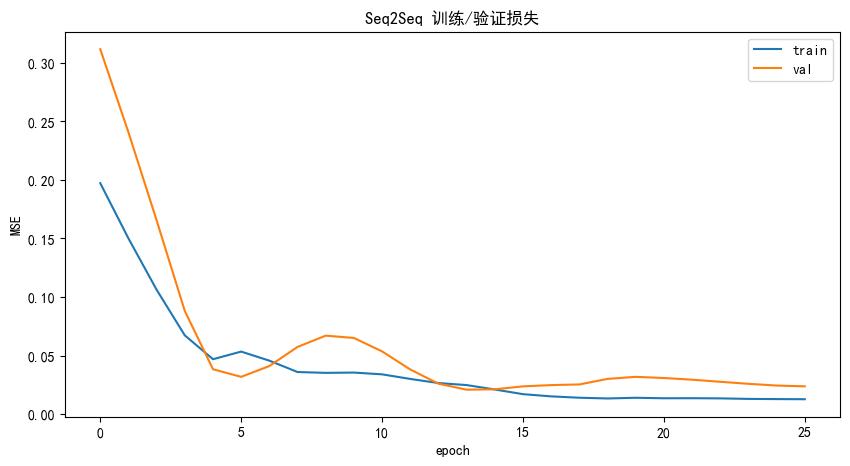

Test inference time: 0.0015027523040771484
===== Seq2Seq Multi-step Metrics (overall flatten) =====
MAE: 0.01477875653654337 RMSE: 0.02082984554878087 R2: 0.2921394109725952
===== Per-horizon Metrics =====
h=1: MAE=0.0116, RMSE=0.0168, R2=0.3827
h=2: MAE=0.0143, RMSE=0.0197, R2=0.3220
h=3: MAE=0.0184, RMSE=0.0251, R2=0.2093
Saved: NDVI_seq2seq_multistep_pred.csv


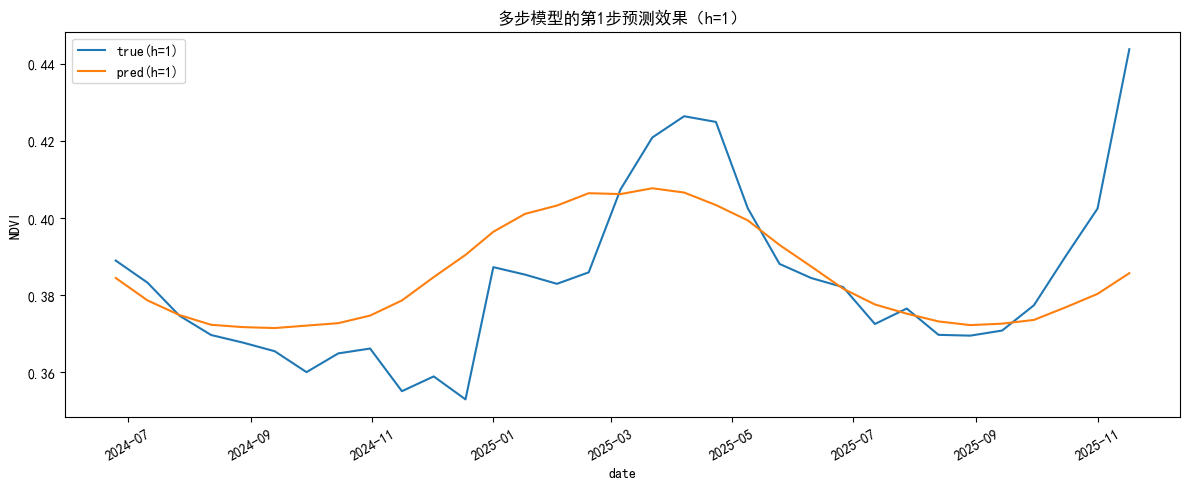

In [21]:

# =========================
# 0) Seed & device
# =========================
fix_seed = 42
random.seed(fix_seed)
np.random.seed(fix_seed)
torch.manual_seed(fix_seed)
torch.cuda.manual_seed_all(fix_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


# =========================
# 1) Config
# =========================
path_load = r'CA_NDVI_SMAP_gridMET_Aligned_2016_2026.csv'

# seq2seq settings
m = 6      # encoder length (history steps)
H = 3      # forecast horizon (future steps)

# training
batch_size = 64
epochs = 120
lr = 1e-3
patience = 12

# model
hidden_size = 64
num_layers = 2
dropout = 0.2


# =========================
# 2) Load & clean
# =========================
df = pd.read_csv(path_load)
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
elif 'timestamp' in df.columns:
    df['date'] = pd.to_datetime(df['timestamp'])
else:
    raise ValueError("CSV need date/timestamp column.")

df = df.sort_values('date').reset_index(drop=True)

required = ['NDVI', 'precipitation', 'soil_moisture', 'temp_max', 'temp_min']
for c in required:
    if c not in df.columns:
        raise ValueError(f"Missing column: {c}")

df['soil_moisture'] = df['soil_moisture'].replace(-9999, np.nan)
if 'smap_count' in df.columns:
    df = df[df['smap_count'] > 0].copy()
df = df.dropna(subset=required).reset_index(drop=True)

# optional: K -> C
df['temp_max'] = df['temp_max'] - 273.15
df['temp_min'] = df['temp_min'] - 273.15

feature_cols = ['precipitation', 'soil_moisture', 'temp_max', 'temp_min']
target_col = 'NDVI'

X_df = df[feature_cols].copy()
y_df = df[[target_col]].copy()


# =========================
# 3) Min-Max normalize (like your style)
# =========================
X_min, X_max = X_df.min(), X_df.max()
y_min, y_max = y_df.min(), y_df.max()

X_den = (X_max - X_min).replace(0, 1)
y_den = (y_max - y_min).replace(0, 1)

X = ((X_df - X_min) / X_den).values.astype(np.float32)
y = ((y_df - y_min) / y_den).values.astype(np.float32).reshape(-1)  # (T,)


# =========================
# 4) Make seq2seq samples
# X: (N, m, F)
# Y: (N, H)   future NDVI sequence
# =========================
X_seq, Y_seq, date_seq = [], [], []

for i in range(len(X) - m - H + 1):
    X_seq.append(X[i:i+m, :])
    Y_seq.append(y[i+m:i+m+H])                # length H
    date_seq.append(df['date'].iloc[i+m:i+m+H].tolist())

X_seq = np.array(X_seq, dtype=np.float32)
Y_seq = np.array(Y_seq, dtype=np.float32)

N = len(X_seq)
print("Samples:", N, "X:", X_seq.shape, "Y:", Y_seq.shape)


# =========================
# 5) Time split
# =========================
train_end = int(N * 0.7)
val_end   = int(N * 0.85)

x_train, y_train = X_seq[:train_end], Y_seq[:train_end]
x_val, y_val     = X_seq[train_end:val_end], Y_seq[train_end:val_end]
x_test, y_test   = X_seq[val_end:], Y_seq[val_end:]
date_test        = date_seq[val_end:]

print("train/val/test:", x_train.shape, x_val.shape, x_test.shape)


# =========================
# 6) Dataset
# =========================
class Seq2SeqDataset(Data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

    def __len__(self):
        return len(self.X)

train_loader = Data.DataLoader(Seq2SeqDataset(x_train, y_train), batch_size=batch_size, shuffle=False)
val_loader   = Data.DataLoader(Seq2SeqDataset(x_val, y_val), batch_size=batch_size, shuffle=False)
test_loader  = Data.DataLoader(Seq2SeqDataset(x_test, y_test), batch_size=batch_size, shuffle=False)


# =========================
# 7) Encoder-Decoder (teacher forcing optional)
# =========================
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

    def forward(self, x):
        _, (h, c) = self.lstm(x)
        return h, c


class Decoder(nn.Module):
    def __init__(self, hidden_size, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1, hidden_size=hidden_size, num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x, h, c):
        out, (h, c) = self.lstm(x, (h, c))
        out = self.fc(out)  # (B, seq, 1)
        return out, (h, c)


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, H):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.H = H

    def forward(self, x, y_true=None, teacher_forcing_ratio=0.5):
        """
        x: (B, m, F)
        y_true: (B, H) scaled NDVI, optional for teacher forcing
        """
        B = x.size(0)
        h, c = self.encoder(x)

        # first decoder input: last observed NDVI (from history) is NOT available here directly,
        # so we use zeros or could use mean. zeros works, but teacher forcing helps.
        dec_in = torch.zeros(B, 1, 1, device=x.device)

        outputs = []
        for t in range(self.H):
            out, (h, c) = self.decoder(dec_in, h, c)  # out: (B,1,1)
            y_hat = out[:, -1, :]                     # (B,1)
            outputs.append(y_hat)

            # next input
            if (y_true is not None) and (random.random() < teacher_forcing_ratio):
                dec_in = y_true[:, t].view(B, 1, 1)   # use ground truth
            else:
                dec_in = y_hat.view(B, 1, 1)          # use prediction

        return torch.cat(outputs, dim=1)  # (B, H)


encoder = Encoder(len(feature_cols), hidden_size, num_layers, dropout)
decoder = Decoder(hidden_size, num_layers, dropout)
model = Seq2Seq(encoder, decoder, H).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# =========================
# 8) Train + Val + Early stopping
# =========================
best_val = float('inf')
wait = 0
save_path = "best_seq2seq_ndvi.pth"

train_losses, val_losses = [], []

def eval_loss(loader):
    model.eval()
    ls = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb, y_true=None, teacher_forcing_ratio=0.0)  # inference-style
            loss = criterion(pred, yb)
            ls.append(loss.item())
    return float(np.mean(ls))

for epoch in tqdm(range(1, epochs + 1)):
    model.train()
    ls = []
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        pred = model(xb, y_true=yb, teacher_forcing_ratio=0.5)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        ls.append(loss.item())

    tr = float(np.mean(ls))
    va = eval_loss(val_loader)

    train_losses.append(tr)
    val_losses.append(va)

    if va < best_val - 1e-8:
        best_val = va
        wait = 0
        torch.save(model.state_dict(), save_path)
    else:
        wait += 1

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | train={tr:.6f} | val={va:.6f} | best_val={best_val:.6f}")

    if wait >= patience:
        print(f"Early stopping at epoch {epoch}, best_val={best_val:.6f}")
        break

# loss plot
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.title('Seq2Seq 训练/验证损失')
plt.legend()
plt.show()


# =========================
# 9) Test predict + inverse scale + metrics per horizon
# =========================
model.load_state_dict(torch.load(save_path, map_location=device))
model.eval()

y_pred_s, y_true_s = [], []

start = time.time()
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        pred = model(xb, y_true=None, teacher_forcing_ratio=0.0).cpu().numpy()  # (B,H)
        y_pred_s.append(pred)
        y_true_s.append(yb.numpy())
end = time.time()

y_pred_s = np.vstack(y_pred_s)  # (N,H)
y_true_s = np.vstack(y_true_s)  # (N,H)
print("Test inference time:", end - start)

# inverse to NDVI
y_pred = y_pred_s * float(y_den.values[0]) + float(y_min.values[0])
y_true = y_true_s * float(y_den.values[0]) + float(y_min.values[0])

# metrics overall + per step
def metrics(a, b):
    mae = mean_absolute_error(a, b)
    rmse = np.sqrt(mean_squared_error(a, b))
    r2 = r2_score(a, b)
    return mae, rmse, r2

print("===== Seq2Seq Multi-step Metrics (overall flatten) =====")
mae_all, rmse_all, r2_all = metrics(y_true.reshape(-1), y_pred.reshape(-1))
print("MAE:", mae_all, "RMSE:", rmse_all, "R2:", r2_all)

print("===== Per-horizon Metrics =====")
for h in range(H):
    mae_h, rmse_h, r2_h = metrics(y_true[:, h], y_pred[:, h])
    print(f"h={h+1}: MAE={mae_h:.4f}, RMSE={rmse_h:.4f}, R2={r2_h:.4f}")

# save predictions
# build a long table: each row = one predicted date
rows = []
for i in range(len(y_pred)):
    for h in range(H):
        rows.append({
            "date": date_test[i][h],
            "horizon": h+1,
            "NDVI_true": y_true[i, h],
            "NDVI_pred": y_pred[i, h]
        })
out_df = pd.DataFrame(rows)
out_df.to_csv("NDVI_seq2seq_multistep_pred.csv", index=False, encoding='utf-8-sig')
print("Saved: NDVI_seq2seq_multistep_pred.csv")

# quick plot: horizon=1 line vs true
h0 = out_df[out_df["horizon"] == 1].copy()
plt.figure(figsize=(12,5))
plt.plot(pd.to_datetime(h0["date"]), h0["NDVI_true"], label="true(h=1)")
plt.plot(pd.to_datetime(h0["date"]), h0["NDVI_pred"], label="pred(h=1)")
plt.title("多步模型的第1步预测效果（h=1）")
plt.xlabel("date")
plt.ylabel("NDVI")
plt.legend()
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


## 残差 Seq2Seq 模型
两项改进：

A. 引入“自回归”特征 (ndvi_lag1)逻辑：模型把“上一个步长的 NDVI”直接喂给模型。意义：植被生长具有极强的滞后性和连贯性。

B. 预测“残差” (Predict $\Delta NDVI$)数学变化：不直接预测 NDVI 的绝对值，而是预测未来 NDVI 与当前值之间的差值（$\Delta y = y_{t+h} - y_t$）。解码器冷启动：解码器的第一个输入不再是 0，而是当前时刻已知的最后一个 NDVI 值 (x[:, -1, NDVI_LAG_IDX])。优势：这相当于给了模型一个“起跳点”。模型只需要学习植被是会“变绿一点”还是“变黄一点”，而不是去猜 NDVI 的具体数值。这大大降低了模型的学习难度，通常能显著提升 $h=3$ 这种长程预测的稳定性。

device: cuda
Samples: 218
train/val/test: (152, 6, 5) (32, 6, 5) (34, 6, 5)


  4%|▍         | 5/120 [00:00<00:02, 47.91it/s]

Epoch 000 | train=0.0228 | val=0.0209
Epoch 005 | train=0.0197 | val=0.0201


 12%|█▎        | 15/120 [00:00<00:02, 46.07it/s]

Epoch 010 | train=0.0154 | val=0.0158
Epoch 015 | train=0.0113 | val=0.0132


 21%|██        | 25/120 [00:00<00:02, 45.91it/s]

Epoch 020 | train=0.0099 | val=0.0127
Epoch 025 | train=0.0096 | val=0.0125
Epoch 030 | train=0.0091 | val=0.0126


 32%|███▎      | 39/120 [00:00<00:01, 46.58it/s]


Epoch 035 | train=0.0088 | val=0.0129
Early stopping at epoch 39


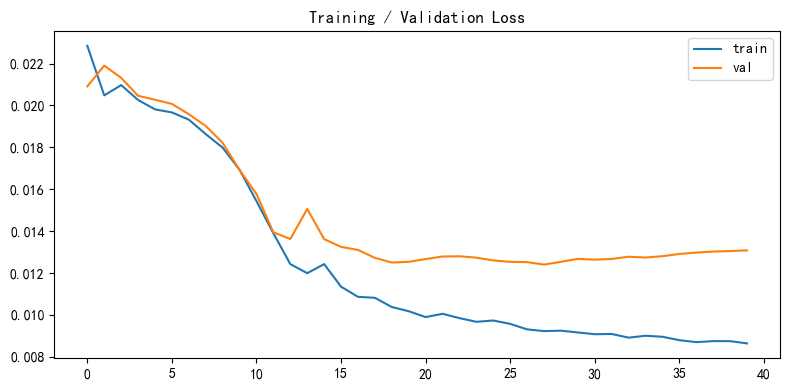

===== Per-horizon Metrics =====
h=1: MAE=0.0079, RMSE=0.0107, R2=0.7245
h=2: MAE=0.0124, RMSE=0.0158, R2=0.4404
h=3: MAE=0.0155, RMSE=0.0210, R2=0.3000


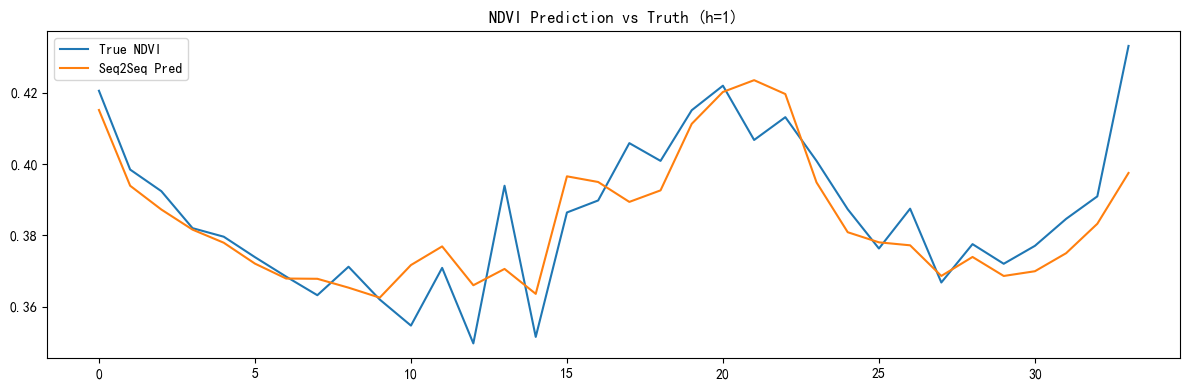

In [22]:
############################################
# Seq2Seq NDVI Multi-step Forecast (Clean)
# Residual learning + NDVI autoregression
############################################

# =========================
# 0) Seed & device
# =========================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


# =========================
# 1) Config
# =========================
CSV_PATH = r'CA_NDVI_SMAP_gridMET_Aligned_2016_2026.csv'

m = 6      # history length
H = 3      # forecast horizon

epochs = 120
batch_size = 64
lr = 1e-3
patience = 12

hidden_size = 64
num_layers = 2
dropout = 0.2


# =========================
# 2) Load & preprocess
# =========================
df = pd.read_csv(CSV_PATH)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# required columns
req = ['NDVI', 'precipitation', 'soil_moisture', 'temp_max', 'temp_min']
for c in req:
    if c not in df.columns:
        raise ValueError(f"Missing column: {c}")

# clean
df['soil_moisture'] = df['soil_moisture'].replace(-9999, np.nan)
df = df.dropna(subset=req).reset_index(drop=True)

# Kelvin → Celsius
df['temp_max'] -= 273.15
df['temp_min'] -= 273.15

# =========================
# 3) Feature engineering
# =========================
# cumulative precip (≈96 days)
df['precip_96d'] = df['precipitation'].rolling(6, min_periods=1).sum()

# NDVI autoregression (核心)
df['ndvi_lag1'] = df['NDVI'].shift(1)

df = df.dropna().reset_index(drop=True)

feature_cols = [
    'precip_96d',
    'soil_moisture',
    'temp_max',
    'temp_min',
    'ndvi_lag1'        # ★ 核心
]
target_col = 'NDVI'

NDVI_LAG_IDX = feature_cols.index('ndvi_lag1')


# =========================
# 4) Normalization
# =========================
X = df[feature_cols].values.astype(np.float32)
y = df[target_col].values.astype(np.float32)

X_min, X_max = X.min(axis=0), X.max(axis=0)
X_den = np.where(X_max - X_min == 0, 1.0, X_max - X_min)
Xn = (X - X_min) / X_den

y_min, y_max = y.min(), y.max()
y_den = y_max - y_min if y_max > y_min else 1.0
yn = (y - y_min) / y_den


# =========================
# 5) Build windows (predict ΔNDVI)
# =========================
def build_windows(X, y, m, H):
    Xs, Ys = [], []
    for i in range(len(X) - m - H + 1):
        Xs.append(X[i:i+m])
        # residual target: NDVI(t+h) - NDVI(t)
        y0 = y[i+m-1]
        Ys.append(y[i+m:i+m+H] - y0)
    return np.array(Xs), np.array(Ys)

X_all, Y_all = build_windows(Xn, yn, m, H)

N = len(X_all)
n_train = int(N * 0.7)
n_val   = int(N * 0.15)

X_tr, Y_tr = X_all[:n_train], Y_all[:n_train]
X_va, Y_va = X_all[n_train:n_train+n_val], Y_all[n_train:n_train+n_val]
X_te, Y_te = X_all[n_train+n_val:], Y_all[n_train+n_val:]

print(f"Samples: {N}")
print("train/val/test:", X_tr.shape, X_va.shape, X_te.shape)

train_loader = Data.DataLoader(
    Data.TensorDataset(torch.tensor(X_tr), torch.tensor(Y_tr)),
    batch_size=batch_size, shuffle=False
)
val_loader = Data.DataLoader(
    Data.TensorDataset(torch.tensor(X_va), torch.tensor(Y_va)),
    batch_size=batch_size, shuffle=False
)
test_loader = Data.DataLoader(
    Data.TensorDataset(torch.tensor(X_te), torch.tensor(Y_te)),
    batch_size=batch_size, shuffle=False
)


# =========================
# 6) Seq2Seq model (correct decoder start)
# =========================
class Encoder(nn.Module):
    def __init__(self, in_dim, hid, layers, drop):
        super().__init__()
        self.lstm = nn.LSTM(in_dim, hid, layers,
                            batch_first=True, dropout=drop)

    def forward(self, x):
        _, (h, c) = self.lstm(x)
        return h, c


class Decoder(nn.Module):
    def __init__(self, hid, layers, drop):
        super().__init__()
        self.lstm = nn.LSTM(1, hid, layers,
                            batch_first=True, dropout=drop)
        self.fc = nn.Linear(hid, 1)

    def forward(self, x, h, c):
        out, (h, c) = self.lstm(x, (h, c))
        return self.fc(out), (h, c)


class Seq2Seq(nn.Module):
    def __init__(self, enc, dec, H):
        super().__init__()
        self.enc, self.dec, self.H = enc, dec, H

    def forward(self, x, y_true=None, tf=0.5):
        B = x.size(0)
        h, c = self.enc(x)

        # decoder starts from NDVI(t)
        dec_in = x[:, -1, NDVI_LAG_IDX].view(B, 1, 1)
        outputs = []

        for t in range(self.H):
            out, (h, c) = self.dec(dec_in, h, c)
            delta = out[:, -1, :]
            outputs.append(delta)

            if y_true is not None and random.random() < tf:
                dec_in = y_true[:, t].view(B, 1, 1)
            else:
                dec_in = delta.view(B, 1, 1)

        return torch.cat(outputs, dim=1)


model = Seq2Seq(
    Encoder(len(feature_cols), hidden_size, num_layers, dropout),
    Decoder(hidden_size, num_layers, dropout),
    H
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()


# =========================
# 7) Training
# =========================
train_loss, val_loss = [], []
best_val, wait = np.inf, 0

for epoch in tqdm(range(epochs)):
    model.train()
    tl = []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb, yb, tf=0.5)
        loss = criterion(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tl.append(loss.item())

    tr = np.mean(tl)
    train_loss.append(tr)

    model.eval()
    vl = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            vl.append(criterion(model(xb, None, 0.0), yb).item())

    va = np.mean(vl)
    val_loss.append(va)

    if va < best_val:
        best_val, wait = va, 0
        torch.save(model.state_dict(), "best_seq2seq.pt")
    else:
        wait += 1

    if epoch % 5 == 0:
        print(f"Epoch {epoch:03d} | train={tr:.4f} | val={va:.4f}")

    if wait >= patience:
        print(f"Early stopping at epoch {epoch}")
        break


# =========================
# 8) Loss curve
# =========================
plt.figure(figsize=(8,4))
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.title("Training / Validation Loss")
plt.tight_layout()
plt.show()


# =========================
# 9) Test & metrics
# =========================
model.load_state_dict(torch.load("best_seq2seq.pt"))
model.eval()

pred_s, true_s = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        pred_s.append(model(xb.to(device), None, 0.0).cpu().numpy())
        true_s.append(yb.numpy())

pred_s = np.vstack(pred_s)
true_s = np.vstack(true_s)

# recover NDVI
last_ndvi = X_te[:, -1, NDVI_LAG_IDX] * y_den + y_min
y_pred = pred_s * y_den + last_ndvi[:, None]
y_true = true_s * y_den + last_ndvi[:, None]


print("===== Per-horizon Metrics =====")
for h in range(H):
    mae = mean_absolute_error(y_true[:, h], y_pred[:, h])
    rmse = np.sqrt(mean_squared_error(y_true[:, h], y_pred[:, h]))
    r2 = r2_score(y_true[:, h], y_pred[:, h])
    print(f"h={h+1}: MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")


# =========================
# 10) Plot prediction vs truth (h=1)
# =========================
plt.figure(figsize=(12,4))
plt.plot(y_true[:, 0], label='True NDVI')
plt.plot(y_pred[:, 0], label='Seq2Seq Pred')
plt.legend()
plt.title("NDVI Prediction vs Truth (h=1)")
plt.tight_layout()
plt.show()


## Tranformer
加入了注意力机制，能够更好地捕捉序列中的长距离依赖关系。

Using device: cuda


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 0 | Train: 0.169357 | Val: 0.102675


  9%|▉         | 14/150 [00:00<00:04, 32.49it/s]

Epoch 10 | Train: 0.018766 | Val: 0.013385


 18%|█▊        | 27/150 [00:00<00:03, 37.87it/s]

Epoch 20 | Train: 0.019216 | Val: 0.011248


 24%|██▍       | 36/150 [00:01<00:02, 38.30it/s]

Epoch 30 | Train: 0.015456 | Val: 0.011509


 32%|███▏      | 48/150 [00:01<00:02, 38.71it/s]

Epoch 40 | Train: 0.016364 | Val: 0.010594


 38%|███▊      | 57/150 [00:01<00:02, 39.83it/s]

Epoch 50 | Train: 0.013697 | Val: 0.011575


 45%|████▍     | 67/150 [00:01<00:02, 40.64it/s]

Epoch 60 | Train: 0.012260 | Val: 0.010419


 51%|█████▏    | 77/150 [00:02<00:01, 40.83it/s]

Epoch 70 | Train: 0.011825 | Val: 0.010205


 55%|█████▍    | 82/150 [00:02<00:01, 37.45it/s]


Epoch 80 | Train: 0.012840 | Val: 0.010199

===== Transformer Metrics =====
h=1: R2=0.7368, MAE=0.0073
h=2: R2=0.4501, MAE=0.0118
h=3: R2=0.3827, MAE=0.0141


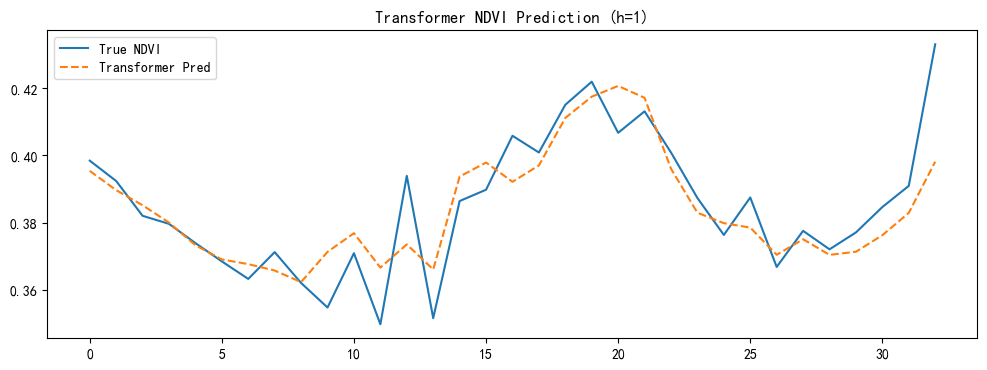

In [23]:

# =========================
# 0) Seed & Device
# =========================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# =========================
# 1) Config
# =========================
CSV_PATH = r'CA_NDVI_SMAP_gridMET_Aligned_2016_2026.csv'

m = 12   # 历史步长
H = 3      # 预测未来步长

epochs = 150
batch_size = 64
lr = 5e-4  # Transformer 建议学习率稍小
patience = 15

d_model = 64    # Transformer 内部维度
nhead = 8       # 多头注意力（必须被 d_model 整除）
num_layers = 3  # Encoder 层数
dropout = 0.1

# =========================
# 2) Data Loading & Processing (沿用你的逻辑)
# =========================
df = pd.read_csv(CSV_PATH)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.sort_values('date').reset_index(drop=True)

req = ['NDVI', 'precipitation', 'soil_moisture', 'temp_max', 'temp_min']
df['soil_moisture'] = df['soil_moisture'].replace(-9999, np.nan)
df = df.dropna(subset=req).reset_index(drop=True)

# 物理量转换
df['temp_max'] -= 273.15
df['temp_min'] -= 273.15
df['precip_96d'] = df['precipitation'].rolling(6, min_periods=1).sum()
df['ndvi_lag1'] = df['NDVI'].shift(1)
df = df.dropna().reset_index(drop=True)

feature_cols = ['precip_96d', 'soil_moisture', 'temp_max', 'temp_min', 'ndvi_lag1']
target_col = 'NDVI'
NDVI_LAG_IDX = feature_cols.index('ndvi_lag1')

# 归一化
X = df[feature_cols].values.astype(np.float32)
y = df[target_col].values.astype(np.float32)

X_min, X_max = X.min(axis=0), X.max(axis=0)
X_den = np.where(X_max - X_min == 0, 1.0, X_max - X_min)
Xn = (X - X_min) / X_den

y_min, y_max = y.min(), y.max()
y_den = y_max - y_min if y_max > y_min else 1.0
yn = (y - y_min) / y_den

# =========================
# 3) Build Windows (残差目标: ΔNDVI)
# =========================
def build_windows(X, y, m, H):
    Xs, Ys = [], []
    for i in range(len(X) - m - H + 1):
        Xs.append(X[i:i+m])
        y0 = y[i+m-1]  # 当前时刻的 NDVI
        Ys.append(y[i+m:i+m+H] - y0) # 预测残差
    return np.array(Xs), np.array(Ys)

X_all, Y_all = build_windows(Xn, yn, m, H)
N = len(X_all)
n_train, n_val = int(N * 0.7), int(N * 0.15)

X_tr, Y_tr = X_all[:n_train], Y_all[:n_train]
X_va, Y_va = X_all[n_train:n_train+n_val], Y_all[n_train:n_train+n_val]
X_te, Y_te = X_all[n_train+n_val:], Y_all[n_train+n_val:]

train_loader = Data.DataLoader(Data.TensorDataset(torch.tensor(X_tr), torch.tensor(Y_tr)), batch_size=batch_size, shuffle=True)
val_loader = Data.DataLoader(Data.TensorDataset(torch.tensor(X_va), torch.tensor(Y_va)), batch_size=batch_size, shuffle=False)
test_loader = Data.DataLoader(Data.TensorDataset(torch.tensor(X_te), torch.tensor(Y_te)), batch_size=batch_size, shuffle=False)

# =========================
# 4) Transformer Model
# =========================


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class NDVI_Transformer(nn.Module):
    def __init__(self, in_dim, d_model, nhead, num_layers, H, dropout):
        super().__init__()
        self.input_fc = nn.Linear(in_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, d_model*4, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_fc = nn.Linear(d_model, H)

    def forward(self, x):
        x = self.input_fc(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        # 取最后一个时间步进行回归预测
        return self.output_fc(x[:, -1, :])

model = NDVI_Transformer(len(feature_cols), d_model, nhead, num_layers, H, dropout).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.MSELoss()

# =========================
# 5) Training Loop
# =========================
train_loss, val_loss = [], []
best_val, wait = np.inf, 0

for epoch in tqdm(range(epochs)):
    model.train()
    tl = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        tl.append(loss.item())
    
    tr_m = np.mean(tl)
    train_loss.append(tr_m)

    model.eval()
    vl = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            vl.append(criterion(model(xb), yb).item())
    
    va_m = np.mean(vl)
    val_loss.append(va_m)

    if va_m < best_val:
        best_val, wait = va_m, 0
        torch.save(model.state_dict(), "best_transformer.pt")
    else:
        wait += 1
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train: {tr_m:.6f} | Val: {va_m:.6f}")
    if wait >= patience: break

# =========================
# 6) Evaluation
# =========================
model.load_state_dict(torch.load("best_transformer.pt"))
model.eval()
preds, trues = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        preds.append(model(xb.to(device)).cpu().numpy())
        trues.append(yb.numpy())

preds, trues = np.vstack(preds), np.vstack(trues)

# 还原 NDVI (加上基准值 y0)
last_ndvi_norm = X_te[:, -1, NDVI_LAG_IDX]
y_pred = preds * y_den + (last_ndvi_norm * y_den + y_min)[:, None]
y_true = trues * y_den + (last_ndvi_norm * y_den + y_min)[:, None]

print("\n===== Transformer Metrics =====")
for h in range(H):
    r2 = r2_score(y_true[:, h], y_pred[:, h])
    mae = mean_absolute_error(y_true[:, h], y_pred[:, h])
    print(f"h={h+1}: R2={r2:.4f}, MAE={mae:.4f}")

# 可视化 (h=1)
plt.figure(figsize=(12,4))
plt.plot(y_true[:, 0], label='True NDVI', color='tab:blue')
plt.plot(y_pred[:, 0], label='Transformer Pred', color='tab:orange', linestyle='--')
plt.title("Transformer NDVI Prediction (h=1)")
plt.legend(); plt.show()


基于 2025-12-19 的最新观测值，未来 3 个周期的预测如下：
日期: 2026-01-04 | 预测 NDVI: 0.4766
日期: 2026-01-20 | 预测 NDVI: 0.4804
日期: 2026-02-05 | 预测 NDVI: 0.4888


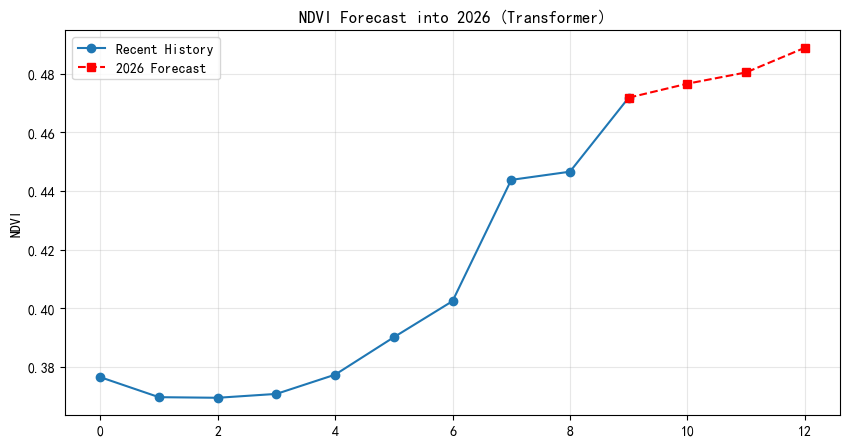

In [24]:
# =========================
# 11) Final Forecast for 2026
# =========================
model.eval()
with torch.no_grad():
    # 提取最后 m 个时间步作为输入
    last_window = torch.tensor(Xn[-m:]).unsqueeze(0).to(device) 
    delta_pred = model(last_window).cpu().numpy()[0]
    
    # 反归一化
    last_ndvi_real = y[-1] # 历史上最后一个真实的 NDVI 值
    forecast_ndvi = delta_pred * y_den + last_ndvi_real
    
    # 获取最后日期并生成未来日期
    last_date = df['date'].iloc[-1]
    future_dates = [last_date + pd.Timedelta(days=16 * i) for i in range(1, H + 1)]

print(f"\n基于 {last_date.date()} 的最新观测值，未来 3 个周期的预测如下：")
for i, d in enumerate(future_dates):
    print(f"日期: {d.date()} | 预测 NDVI: {forecast_ndvi[i]:.4f}")

# 可视化最后一段趋势 + 预测
plt.figure(figsize=(10, 5))
recent_ndvi = y[-10:]
plt.plot(range(10), recent_ndvi, marker='o', label='Recent History')
plt.plot(range(9, 9 + H + 1), [recent_ndvi[-1]] + list(forecast_ndvi), 
         marker='s', linestyle='--', color='red', label='2026 Forecast')
plt.title("NDVI Forecast into 2026 (Transformer)")
plt.ylabel("NDVI")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 自动调参Transformer
学习率调度器 (ReduceLROnPlateau)：它会像“扫描仪”一样监控你的 Val Loss。如果损失连续 5 个 Epoch 没下降，它会自动降低学习率，让模型进入“微调模式”。

增强泛化约束：将 dropout 提高到 0.2 并增加了 weight_decay，这能防止大模型在 $h=3$ 这种高噪声预测中过拟合。



Using device: cuda


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0 | Train: 0.154423 | Val: 0.101511 | LR: 1.00e-03


  6%|▌         | 11/200 [00:00<00:03, 51.18it/s]

Epoch 10 | Train: 0.031456 | Val: 0.014705 | LR: 1.00e-03


  8%|▊         | 17/200 [00:00<00:03, 51.08it/s]

Epoch 20 | Train: 0.019423 | Val: 0.012495 | LR: 1.00e-03


 14%|█▍        | 29/200 [00:00<00:03, 53.65it/s]

Epoch 30 | Train: 0.016379 | Val: 0.012506 | LR: 2.50e-04


 18%|█▊        | 35/200 [00:00<00:03, 53.04it/s]

Epoch 40 | Train: 0.015517 | Val: 0.011444 | LR: 1.25e-04

 24%|██▎       | 47/200 [00:00<00:02, 52.96it/s]


Epoch 50 | Train: 0.015685 | Val: 0.011598 | LR: 6.25e-05


 32%|███▏      | 64/200 [00:01<00:02, 51.25it/s]


Epoch 60 | Train: 0.016040 | Val: 0.011142 | LR: 3.13e-05
Early Stopping at Epoch 64

===== Optimized Transformer Metrics =====
h=1: R2=0.7204, MAE=0.0075, RMSE=0.0105
h=2: R2=0.4620, MAE=0.0116, RMSE=0.0154
h=3: R2=0.3289, MAE=0.0154, RMSE=0.0207


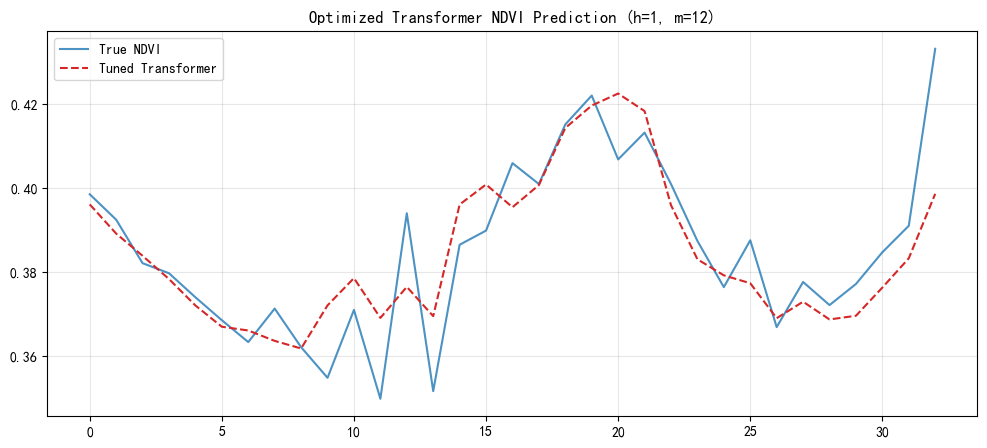

In [25]:
# =========================
# 0) Seed & Device
# =========================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# =========================
# 1) Config - 优化参数版
# =========================
CSV_PATH = r'CA_NDVI_SMAP_gridMET_Aligned_2016_2026.csv'

m = 12          # 历史步长（覆盖一年周期）
H = 3           # 预测未来步长

epochs = 200    # 增加上限，靠 Early Stopping 停止
batch_size = 64
lr = 1e-3       # 初始学习率设高一点，让 Scheduler 自动去降
patience = 20   # 容忍度稍微提高

d_model = 64  
nhead = 8       
num_layers = 2  
dropout = 0.2   # 提高到 0.2，增强泛化能力，保住 h=3 的精度

# =========================
# 2) Data Loading & Processing
# =========================
df = pd.read_csv(CSV_PATH)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.sort_values('date').reset_index(drop=True)

req = ['NDVI', 'precipitation', 'soil_moisture', 'temp_max', 'temp_min']
df['soil_moisture'] = df['soil_moisture'].replace(-9999, np.nan)
df = df.dropna(subset=req).reset_index(drop=True)

df['temp_max'] -= 273.15
df['temp_min'] -= 273.15
df['precip_96d'] = df['precipitation'].rolling(6, min_periods=1).sum()
df['ndvi_lag1'] = df['NDVI'].shift(1)
df = df.dropna().reset_index(drop=True)

feature_cols = ['precip_96d', 'soil_moisture', 'temp_max', 'temp_min', 'ndvi_lag1']
target_col = 'NDVI'
NDVI_LAG_IDX = feature_cols.index('ndvi_lag1')

X = df[feature_cols].values.astype(np.float32)
y = df[target_col].values.astype(np.float32)

X_min, X_max = X.min(axis=0), X.max(axis=0)
X_den = np.where(X_max - X_min == 0, 1.0, X_max - X_min)
Xn = (X - X_min) / X_den

y_min, y_max = y.min(), y.max()
y_den = y_max - y_min if y_max > y_min else 1.0
yn = (y - y_min) / y_den

# =========================
# 3) Build Windows
# =========================
def build_windows(X, y, m, H):
    Xs, Ys = [], []
    for i in range(len(X) - m - H + 1):
        Xs.append(X[i:i+m])
        y0 = y[i+m-1]
        Ys.append(y[i+m:i+m+H] - y0)
    return np.array(Xs), np.array(Ys)

X_all, Y_all = build_windows(Xn, yn, m, H)
N = len(X_all)
n_train, n_val = int(N * 0.7), int(N * 0.15)

X_tr, Y_tr = X_all[:n_train], Y_all[:n_train]
X_va, Y_va = X_all[n_train:n_train+n_val], Y_all[n_train:n_train+n_val]
X_te, Y_te = X_all[n_train+n_val:], Y_all[n_train+n_val:]

train_loader = Data.DataLoader(Data.TensorDataset(torch.tensor(X_tr), torch.tensor(Y_tr)), batch_size=batch_size, shuffle=True)
val_loader = Data.DataLoader(Data.TensorDataset(torch.tensor(X_va), torch.tensor(Y_va)), batch_size=batch_size, shuffle=False)
test_loader = Data.DataLoader(Data.TensorDataset(torch.tensor(X_te), torch.tensor(Y_te)), batch_size=batch_size, shuffle=False)

# =========================
# 4) Model Architecture
# =========================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class NDVI_Transformer(nn.Module):
    def __init__(self, in_dim, d_model, nhead, num_layers, H, dropout):
        super().__init__()
        self.input_fc = nn.Linear(in_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, d_model*4, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_fc = nn.Linear(d_model, H)

    def forward(self, x):
        x = self.input_fc(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        return self.output_fc(x[:, -1, :])

model = NDVI_Transformer(len(feature_cols), d_model, nhead, num_layers, H, dropout).to(device)

# 增加 Weight Decay (L2 正则化) 防止大模型过拟合
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-3)

# ★ 学习率调度器：当 Val Loss 5次不下降，学习率减半
# ★ 学习率调度器：只需删掉 verbose=True
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
criterion = nn.MSELoss()

# =========================
# 5) Training Loop
# =========================
train_loss, val_loss = [], []
best_val, wait = np.inf, 0

for epoch in tqdm(range(epochs)):
    model.train()
    tl = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        tl.append(loss.item())
    
    tr_m = np.mean(tl)
    train_loss.append(tr_m)

    model.eval()
    vl = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            vl.append(criterion(model(xb), yb).item())
    
    va_m = np.mean(vl)
    val_loss.append(va_m)

    # 更新调度器
    scheduler.step(va_m)

    if va_m < best_val:
        best_val, wait = va_m, 0
        torch.save(model.state_dict(), "best_transformer_tuned.pt")
    else:
        wait += 1
    
    if epoch % 10 == 0:
        curr_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch} | Train: {tr_m:.6f} | Val: {va_m:.6f} | LR: {curr_lr:.2e}")
    if wait >= patience: 
        print(f"Early Stopping at Epoch {epoch}")
        break

# =========================
# 6) Evaluation & Recover
# =========================
model.load_state_dict(torch.load("best_transformer_tuned.pt"))
model.eval()
preds, trues = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        preds.append(model(xb.to(device)).cpu().numpy())
        trues.append(yb.numpy())

preds, trues = np.vstack(preds), np.vstack(trues)

last_ndvi_norm = X_te[:, -1, NDVI_LAG_IDX]
y_pred = preds * y_den + (last_ndvi_norm * y_den + y_min)[:, None]
y_true = trues * y_den + (last_ndvi_norm * y_den + y_min)[:, None]

print("\n===== Optimized Transformer Metrics =====")
for h in range(H):
    r2 = r2_score(y_true[:, h], y_pred[:, h])
    mae = mean_absolute_error(y_true[:, h], y_pred[:, h])
    rmse = np.sqrt(mean_squared_error(y_true[:, h], y_pred[:, h]))
    print(f"h={h+1}: R2={r2:.4f}, MAE={mae:.4f}, RMSE={rmse:.4f}")

# 可视化
plt.figure(figsize=(12,5))
plt.plot(y_true[:, 0], label='True NDVI', color='tab:blue', alpha=0.8)
plt.plot(y_pred[:, 0], label='Tuned Transformer', color='tab:red', linestyle='--')
plt.title(f"Optimized Transformer NDVI Prediction (h=1, m={m})")
plt.legend(); plt.grid(True, alpha=0.3); plt.show()